# Snickometer - Automation Lab

In [37]:
import IPython
from scipy.io import wavfile
import scipy.signal
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
%matplotlib inline

## Load Data

In [38]:
wav_loc = "wav/ballonbat8.wav"
data, sr = librosa.load(wav_loc)

## Visualising Original Audio

In [39]:
IPython.display.Audio(data=data, rate=sr)

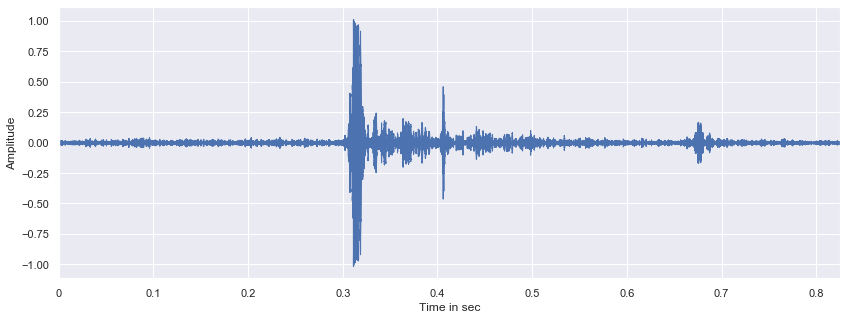

In [40]:
import librosa.display
sns.set()
plt.figure(figsize=(14,5))
librosa.display.waveplot(data, sr=sr)
plt.xlabel("Time in sec")
plt.ylabel("Amplitude")
plt.show()

## Removing the noise

In [41]:
nois_loc = "noise31.wav"
ns_data, ns_sr = librosa.load(wav_loc)
noise_clip = ns_data[: len(data)]
snr = 1  # signal to noise ratio
noise_clip = noise_clip / snr

In [42]:
import noisereduce as nr
output = nr.reduce_noise(audio_clip=data, noise_clip=noise_clip,verbose=False)
#output = nr.reduce_noise(audio_clip=data, noise_clip=noise_clip,verbose=True)
max_ind= output.argmax()

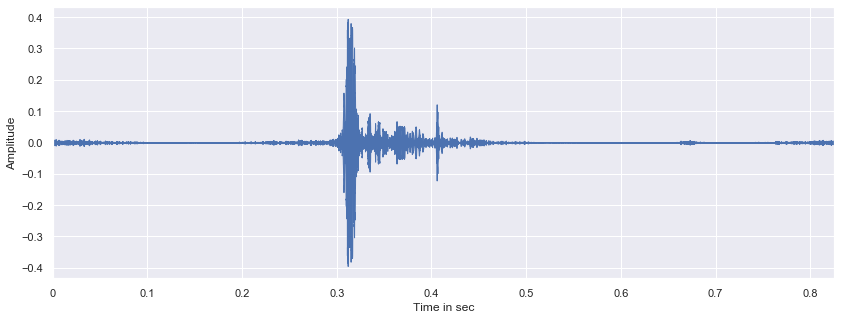

In [43]:
plt.figure(figsize=(14,5))
librosa.display.waveplot(output, sr=sr)
plt.xlabel("Time in sec")
plt.ylabel("Amplitude")
plt.show()
IPython.display.Audio(data=output, rate=44100)

## Frequency Domain Plot

In [44]:
import scipy
def fft_plot(audio,samp_rate):
    n=len(audio)
    T=1/samp_rate
    yf=scipy.fft(audio)
    xf=np.linspace(0.0,1.0/(2*T),n/2)
    fig,ax =plt.subplots()
    ax.plot(xf, 2.0/n * np.abs(yf[:n//2]))
    sns.set()
    #plt.grid()
    plt.xlabel("Frequency")
    plt.ylabel("Amplitude")
    return plt.show()

C:\Users\Nikhil\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  


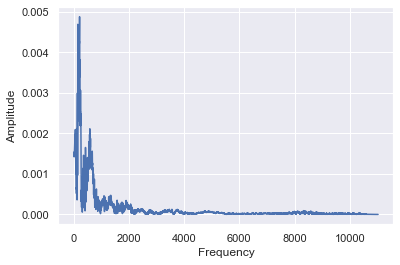

In [45]:
fft_plot(output,sr)

## Feature Extraction

 ### 1. Spectrogram

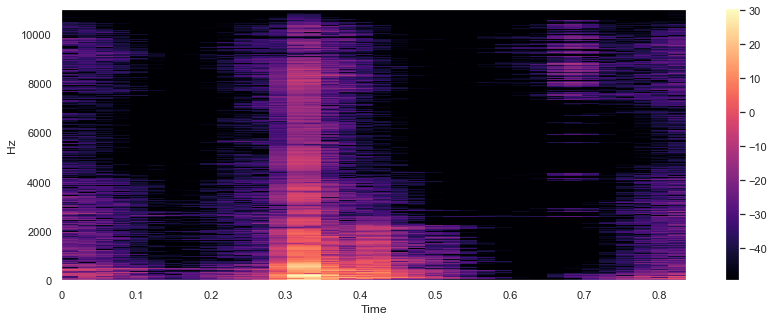

In [46]:
#display Spectrogram
X = librosa.stft(output)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz') 
plt.colorbar()

### Zoom in

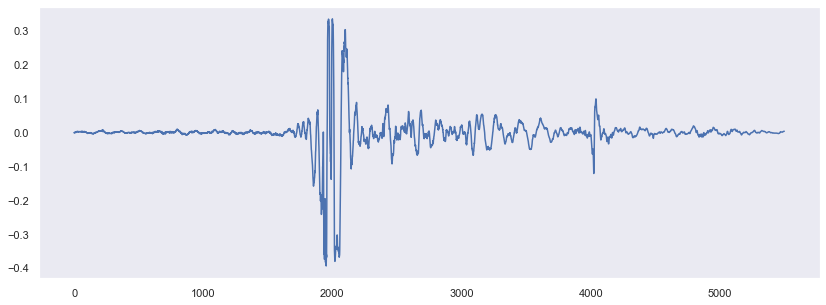

In [47]:
# Zooming in
if (max_ind-2000 >0):
    n0=max_ind-2000
else:
    n0=0
if (max_ind+3500 < len(output)):
    n1=max_ind+3500
else:
    n1=len(output)
    
plt.figure(figsize=(14, 5))
plt.plot(output[n0:n1])
plt.grid()

### 2.Spectral centroid

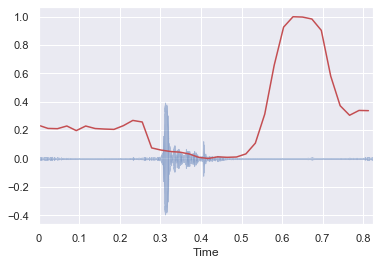

In [48]:
#spectral centroid 
import sklearn
spectral_centroids = librosa.feature.spectral_centroid(output, sr=sr)[0]
spectral_centroids.shape
# Computing the time variable for visualization
frames = range(len(spectral_centroids))
t = librosa.frames_to_time(frames)
# Normalising the spectral centroid for visualisation
def normalize(output, axis=0):
    return sklearn.preprocessing.minmax_scale(output, axis=axis)
#Plotting the Spectral Centroid along the waveform
librosa.display.waveplot(output, sr=sr, alpha=0.4)
plt.plot(t, normalize(spectral_centroids), color='r')

### 3.Spectral Roll off

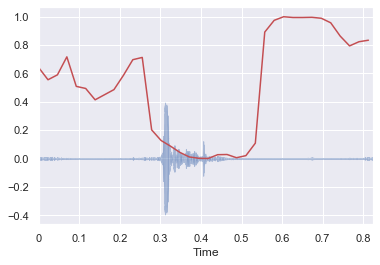

In [49]:
#spectral roll off
spectral_rolloff = librosa.feature.spectral_rolloff(output, sr=sr)[0]
librosa.display.waveplot(output, sr=sr, alpha=0.4)
plt.plot(t, normalize(spectral_rolloff), color='r')

## Numerical Extraction

### 1.Spectral Centroid

In [50]:
cent = librosa.feature.spectral_centroid(y=output, sr=sr)
cent_mean=np.mean(cent)
cent_std=np.std(cent)
cent_skew=scipy.stats.skew(cent,axis=1)[0]
print('Mean: '+str(cent_mean))
print('SD: '+str(cent_std))
print('Skewness: '+str(cent_skew))

Mean: 3127.2662560499416
SD: 2207.7428696701854
Skewness: 1.2697715279903101


### 2.Spectral Roll off

In [51]:
rolloff = librosa.feature.spectral_rolloff(y=output, sr=sr)
rolloff_mean=np.mean(rolloff)
rolloff_std=np.std(rolloff)
rolloff_skew=scipy.stats.skew(rolloff,axis=1)[0]
print('Mean: '+str(rolloff_mean))
print('SD: '+str(rolloff_std))
print('Skewness: '+str(rolloff_skew))

Mean: 5884.246826171875
SD: 2956.6956827490762
Skewness: -0.1811238078737315


### 3.Zero Crossing

In [52]:
#zero crossings
zero_crossings = librosa.zero_crossings(output[n0:n1], pad=False)
zero_cross=sum(zero_crossings)
print('Zero crossing: '+str(zero_cross))

Zero crossing: 303


### 4.Tempo

In [53]:
y_harmonic, y_percussive = librosa.effects.hpss(output)
tempo, beat_frames = librosa.beat.beat_track(y=y_harmonic, sr=sr)
print('Detected Tempo: '+str(tempo)+ ' beats/min')

Detected Tempo: 123.046875 beats/min


## Take Decision and write output file

In [54]:
import os
if(cent_mean>2500 and cent_mean < 4000 and rolloff_mean >5500 and rolloff_mean < 7500 ):
    ball_hit=True
else:
    ball_hit=False
    
if((tempo >100 and tempo < 250) and (zero_cross < 550 ) and ball_hit ):
    decision="Not Out!!"
    face='\N{smiling face with smiling eyes}'
    
elif((tempo > 100 and tempo < 300) and (zero_cross > 550) and ball_hit):
    decision="Out!!"
    face='\N{pensive face}'
else :
    decision="oops!!"
    face='\N{upside-down face}'
    
if os.path.exists("control.txt"):
    os.remove("control.txt")     
f = open("control.txt","w")
f.write(decision)
f.close()  
print (decision)
print(" "+face)

Not Out!!
 😊


## END